<a href="https://colab.research.google.com/github/ansonmiu0214/C490CW/blob/master/Sentence_Level_QE_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CO490 Coursework: Quality Estimation

__Team__
* Anson Miu (kcm116)
* Cheryl Chen (czc16)
* Clara Gila (acg116)

## Setup

In [0]:
# Imports
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
# Setup CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch_device = getattr(torch, str(device))
torch_device.empty_cache()
print(f'DEVICE={torch_device.get_device_name()}')
print(torch.cuda.memory_summary(device=device))

DEVICE=Tesla T4
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     782 MB |    9195 MB |    2627 GB |    2626 GB |
|       from large pool |     773 MB |    9179 MB |    2573 GB |    2572 GB |
|       from small pool |       9 MB |      41 MB |      54 GB |      54 GB |
|---------------------------------------------------------------------------|
| Active memory         |     782 MB |    9195 MB |    2627 GB |    2626 GB |
|       from large pool |     773 MB |    9179 M

## Utilities

### Loading Data

In [0]:
if not os.path.exists('enzh_data.zip'):
    !wget -O enzh_data.zip https://competitions.codalab.org/my/datasets/download/03e23bd7-8084-4542-997b-6a1ca6dd8a5f
    !unzip enzh_data.zip

TRAIN_EN = 'train.enzh.src'
TRAIN_ZH = 'train.enzh.mt'
TRAIN_SCORES = 'train.enzh.scores'
VAL_EN = 'dev.enzh.src'
VAL_ZH = 'dev.enzh.mt'
VAL_SCORES = 'dev.enzh.scores'
TEST_EN = 'test.enzh.src'
TEST_ZH = 'test.enzh.mt'

In [0]:
# Read from file

with open(TRAIN_EN) as f:
    train_en = f.readlines()
with open(TRAIN_ZH) as f:
    train_zh = f.readlines()
with open(TRAIN_SCORES) as f:
    train_scores = [float(score.strip()) for score in f]
with open(VAL_EN) as f:
    val_en = f.readlines()
with open(VAL_ZH) as f:
    val_zh = f.readlines()
with open(VAL_SCORES) as f:
    val_scores = [float(score.strip()) for score in f]
with open(TEST_EN) as f:
    test_en = f.readlines()
with open(TEST_ZH) as f:
    test_zh = f.readlines()

### Metrics

In [0]:
from scipy.stats import pearsonr

def RMSELoss(pred, target):
    is_numpy = isinstance(pred, np.ndarray) and isinstance(target, np.ndarray)

    mean = np.mean if is_numpy else torch.mean
    sqrt = np.sqrt if is_numpy else torch.sqrt
    return sqrt(mean((pred - target) ** 2))

def pearson(pred, target):
    if not isinstance(pred, np.ndarray):
        pred = pred.numpy()

    if not isinstance(target, np.ndarray):
        target = target.numpy()

    score, _ = pearsonr(pred, target)
    return score

from sklearn.metrics import make_scorer
pearson_sklearn = make_scorer(pearson, greater_is_better=True)

### Data Processing

In [0]:
def concat_zip(en_embs, zh_embs):
    if isinstance(en_embs, list):
        en_embs = torch.cat(en_embs)
    if isinstance(zh_embs, list):
        zh_embs = torch.cat(zh_embs)
    return torch.cat((en_embs, zh_embs), dim=1)


class SourceMTDataset(Dataset):
    def __init__(self, inputs, output):
        assert isinstance(inputs, list), f'Expected type of inputs to be list, got {type(inputs)}'

        self.inputs = inputs
        self.output = output

    def __getitem__(self, index):
        return [input_[index] for input_ in self.inputs], self.output[index]

    def __len__(self):
        return len(self.output)

def build_dataset(*, X, Y, idxs=None):
    if idxs is not None:
        X = [input_[idxs] for input_ in X]
        Y = Y[idxs]

    Cnstr = torch.LongTensor if type(X[0]) == np.ndarray else torch.FloatTensor

    inputs_tensors = [Cnstr(input_) for input_ in X]
    return SourceMTDataset(inputs_tensors, Y)

### Model Training

In [0]:
from pprint import PrettyPrinter

pp = PrettyPrinter()

def suppress_log(*args, **kwargs):
    pass

def debug_log(*args, **kwargs):
    print('[Debug]:', end='')
    print(*args, **kwargs)

### Cross-Validation

In [0]:
def torch_model_factory(model, *, opt, lr, num_epochs, batch_size, loss_fn, detailed_log=True):

    
    def fit(dataset):
        # Enter train mode
        model.train()
        model.to(device)

        # Construct data loader
        loader = DataLoader(dataset=dataset, batch_size=batch_size)

        optimiser = opt(model.parameters(), lr=lr)
        
        losses = []
        epoch_progress = range(1, num_epochs + 1)
        if not detailed_log:
            epoch_progress = tqdm(epoch_progress, desc='Epoch')

        for epoch in epoch_progress:
            if detailed_log:
                header = f'Epoch {epoch}'
                print(header)
                print('=' * len(header))

            progress = loader
            if detailed_log:
                progress = tqdm(progress,
                                desc=f'Training: Mini-Batch SGD (size={batch_size})')
            for X, scores in progress:
                optimiser.zero_grad()

                pred = model(*(x.to(device) for x in X)).squeeze()
            
                loss = loss_fn(pred, scores.to(device))

                loss.backward()
                optimiser.step()
            
                losses.append(loss.cpu().detach().numpy())
            
            if detailed_log:
                print(f'Most recent loss:', loss.cpu().detach().numpy())
                print()
        return losses

    def predict(dataset, **metrics):
        # Enter evaluation mode
        model.eval()
        model.to(device)

        loader = DataLoader(dataset=dataset, batch_size=1)

        preds = []
        scores = []
        with torch.no_grad():
            for X, score in tqdm(loader, desc='Validating'):
                pred = model(*(x.to(device) for x in X)).squeeze().cpu()
                preds.append(pred)
                scores.append(score)
        
            preds = torch.stack(preds)
            scores = torch.cat(scores)

            loss = loss_fn(preds, scores)
            metric_scores = {name: metric_fn(preds, scores)
                        for name, metric_fn in metrics.items()}
            return loss, metric_scores

    def evaluate(train_dataset, test_dataset, **metrics):
        model.to(device)

        # Construct data loaders
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
        test_loader = DataLoader(dataset=test_dataset, batch_size=1)

        # Setup training
        optimiser = opt(model.parameters(), lr=lr)
        
        train_losses = []
        val_losses = []
        val_metrics = {metric: [] for metric in metrics}

        epoch_progress = range(1, num_epochs + 1)
        if not detailed_log:
            epoch_progress = tqdm(epoch_progress, desc='Epoch')

        for epoch in epoch_progress:
            if detailed_log:
                header = f'Epoch {epoch}'
                print(header)
                print('=' * len(header))

            progress = train_loader
            if detailed_log:
                progress = tqdm(progress,
                                desc=f'Training: Mini-Batch SGD (size={batch_size})')
                
            model.train()
            for X, scores in progress:
                optimiser.zero_grad()

                pred = model(*(x.to(device) for x in X)).squeeze()
            
                loss = loss_fn(pred, scores.to(device))

                loss.backward()
                optimiser.step()
            
            # Only append most recent loss
            train_losses.append(loss.cpu().detach().numpy())
            
            if detailed_log:
                print(f'Most recent loss:', loss.cpu().detach().numpy())
                print()

            # Validation
            preds = []
            scores = []
            with torch.no_grad():
                model.eval()
                for X, score in tqdm(test_loader, desc='Validating'):
                    pred = model(*(x.to(device) for x in X)).squeeze().cpu()
                    preds.append(pred)
                    scores.append(score)
            
                preds = torch.stack(preds)
                scores = torch.cat(scores)

                loss = loss_fn(preds, scores)
                metric_scores = {name: metric_fn(preds, scores)
                                 for name, metric_fn in metrics.items()}

                val_losses.append(loss.cpu().detach().numpy())
                for name, metric in metric_scores.items():
                    val_metrics[name].append(metric)
        
        return train_losses, val_losses, val_metrics

    model.fit = fit
    model.predict = predict
    model.evaluate = evaluate

    return lambda: model


In [0]:
from sklearn.model_selection import KFold

def torch_kfold_cross_validate(make_model, *,
                               inputs,
                               outputs,
                               n_splits=2,
                               random_state=0,
                               **metrics):

    # Convert output scores to PyTorch tensor.
    if not isinstance(outputs, torch.FloatTensor):
        outputs = torch.FloatTensor(outputs)
    
    if not isinstance(inputs, list):
        inputs = [inputs]
    
    # Reset seeding
    torch.manual_seed(random_state)
    if device == 'cuda':
        torch.cuda.manual_seed(random_state)
    np.random.seed(random_state)

    cv_split = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    total_loss = 0
    total_metrics = {metric: 0 for metric in metrics}

    for fold, (train_idxs, test_idxs) in enumerate(cv_split.split(inputs[0])):
        print(f'>> Fold {fold + 1}')

        # Create new model.
        model = make_model()

        train_set = build_dataset(X=inputs, Y=outputs, idxs=train_idxs)
        test_set = build_dataset(X=inputs, Y=outputs, idxs=test_idxs)

        # Training
        model.fit(train_set)

        # Evaluation
        loss, metric_scores = model.predict(test_set, **metrics)

        total_loss += loss
        total_metrics = {name: total_metrics[name] + metric_scores[name]
                         for name in metrics}

        print()

    total_loss /= n_splits
    total_metrics = {name: total_metrics[name] / n_splits
                     for name in metrics}
    return total_loss, total_metrics

## Building Blocks

### Preprocessing

#### English

In [138]:
# Downloading spacy models for English

!spacy download en_core_web_md
!spacy link en_core_web_md en300 --force

# Downloading stop words for English

from nltk import download
from nltk.corpus import stopwords

download('stopwords')
stop_words_en = set(stopwords.words('english'))

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_md -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en300
You can now load the model via spacy.load('en300')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Get tokenizer

import spacy

nlp_en = spacy.load('en300')

def preprocess_en(sentence=None, *, keep_stopwords=False):
    """Preprocess English sentence using spaCy for tokenisation.
    Toggle `keep_stopwords=True` to preserve stopwords."""

    def wrapper(sentence):
        text = sentence.lower()
        processed = [token.lemma_ for token in nlp_en.tokenizer(text)]
        processed = [token for token in processed if token.isalpha()]
        if not keep_stopwords:
            processed = [token for token in processed if token not in stop_words_en]
        return processed

    return wrapper if sentence is None else wrapper(sentence)

#### Chinese

In [0]:
# Download stopwords
FILE_STOP_WORDS_ZH = './chinese_stop_words.txt'

if not os.path.exists(FILE_STOP_WORDS_ZH):
    !wget -c https://github.com/Tony607/Chinese_sentiment_analysis/blob/master/data/chinese_stop_words.txt

with open(FILE_STOP_WORDS_ZH, 'r', encoding='utf-8') as f:
    stop_words_zh = [line.rstrip() for line in f]

In [0]:
import jieba

def preprocess_zh(sentence=None, *, keep_stopwords=False):
    """Preprocess Chinese sentence using jieba for tokenisation.
    Toggle `keep_stopwords=True` to preserve stopwords."""
    
    def wrapper(sentence):
        tokens = jieba.cut(sentence, cut_all=False)
        processed = [token for token in tokens if token.isalnum()]
        if not keep_stopwords:
            processed = [token for token in processed if token not in stop_words_zh]
        return processed

    return wrapper if sentence is None else wrapper(sentence)

### Pretrained Word Embeddings

#### English

In [0]:
import torchtext

glove = torchtext.vocab.GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip:  16%|█▌        | 140M/862M [00:48<04:08, 2.91MB/s]


KeyboardInterrupt: ignored

#### Chinese

In [0]:
ZH_MODEL_BIN = 'model.bin'

if not os.path.exists(ZH_MODEL_BIN):
    !wget -O zh.zip http://vectors.nlpl.eu/repository/20/35.zip
    !unzip zh.zip 

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

wv_from_bin = KeyedVectors.load_word2vec_format(ZH_MODEL_BIN, binary=True) 

### Sentence Representation

In [0]:
def pad_sentences(sents, *, pad_token=0):
    """Pad sentences with `pad_token` to the longest sentence in `sents."""

    # Get max sentence length
    sent_lengths = [len(sent) for sent in sents]
    max_sent_len = max(sent_lengths)
    
    # Create empty matrix with padding tokens
    padded_sents = np.ones((len(sents), max_sent_len)) * pad_token

    # Copy over the sequences
    for i, (sent_len, sent) in enumerate(zip(sent_lengths, sents)):
        padded_sents[i, 0:sent_len] = sent[:sent_len]
    return padded_sents

### Vocabulary Representation

In [0]:
class Language(object):

    PAD_TOKEN = '<PAD>'
    UNK_TOKEN = '<UNK>'

    def __init__(self, name):
        self.name = name
        self.word2idx = {}
        self.idx2word = {0: self.PAD_TOKEN,
                         1: self.UNK_TOKEN}

    def __len__(self):
        return len(self.idx2word)

    def add_sentence(self, sentence):
        for token in sentence:
            self.add_word(token)

    def add_word(self, word):
        if word not in self.word2idx:
            idx = len(self)
            self.word2idx[word] = idx
            self.idx2word[idx] = word
    
    def sent_to_idxs(self, sent):
        return [self.word2idx.get(word, 1) for word in sent]

    def __getitem__(self, key):
        if isinstance(key, int):
            return self.idx2word[key]
        if isinstance(key, str):
            return self.word2idx[key]
        raise KeyError(key)
    
    def __repr__(self):
        return f'Language(name={self.name}) with {len(self)} words'

### BERT

In [144]:
!pip install pytorch-pretrained-bert

from pytorch_pretrained_bert import BertConfig, BertTokenizer, BertForSequenceClassification, BertModel
from pytorch_pretrained_bert.optimization import BertAdam

#### Tokenizer

In [0]:
def sentence_groups_to_bert_tokens(tokenizer, *sents, max_length=256):
    assert len(sents) > 0, 'No sentences to tokenise!'

    bert_inputs = []
    num_reserved_markers = 3

    for sent_group in zip(*sents):
        sent_tokens = [tokenizer.tokenize(sent) for sent in sent_group]
        total_length = sum([len(sent) for sent in sent_tokens]) + num_reserved_markers
        if total_length > max_length:
            raise Exception(f'Too long ({total_length} > {max_length})')

        tokens = ['[CLS]']
        for sent in sent_tokens:
            tokens += sent
            tokens.append('[SEP]')
        
        ids = tokenizer.convert_tokens_to_ids(tokens)

        # Apply sentence length padding
        padding = [0] * (max_length - len(ids))
        ids_tensor = torch.LongTensor(ids + padding)
        bert_inputs.append(ids_tensor)

    return torch.stack(bert_inputs)

#### Language Model

In [0]:
import math

def get_bert_embeddings(bert_lm, input_ids, *, batch_size=25):
    bert_lm.to(device)

    num_batches = math.ceil(len(input_ids) / batch_size)

    embs = []
    for batch_id in tqdm(range(num_batches), desc='Batch'):
        start_id = batch_id * batch_size
        end_id = (batch_id + 1) * batch_size
        input_id_batch = input_ids[start_id:end_id]

        if isinstance(bert_lm, BertForSequenceClassification):
            emb = bert_lm(input_id_batch.to(device))
        else:
            _, emb = bert_lm(input_id_batch.to(device))
        embs.append(emb.detach().cpu())

    return embs

## Models

### 1) Fine-tuning Baseline Regressor
---

__Pipeline__



__Model selection__

We perform 2-fold cross validation to select

__Evaluation__
...

#### Pipeline

### 2) Baseline with FFNN Regressor

#### Pipeline

1. Manual preprocessing
    * EN - tokenisation with [spaCy](https://spacy.io),
    stopword removal
    * ZH - tokenisation with [jieba](https://github.com/fxsjy/jieba),
    stopword removal, 
2. Pretrained embeddings
    * EN - GloVe
    * ZH - TODO
3. Regression model
    * SVR
    * LinearRegression

#### Model Architectures

### 3) Autoencoder with Quality Estimation Vectors

#### Pipeline

In [147]:
##########
# ENGLISH
##########

preprocess_english = preprocess_en(keep_stopwords=False)
train_en_sents = [preprocess_english(sent) for sent in train_en]
val_en_sents = [preprocess_english(sent) for sent in val_en]
test_en_sents = [preprocess_english(sent) for sent in test_en]

EN = Language('EN')
for sent in train_en_sents:
    EN.add_sentence(sent)
print(EN)

print()
print('Sample sentence')
sample_sent_en = train_en_sents[42]
print(sample_sent_en)
print(EN.sent_to_idxs(sample_sent_en))

train_en_idxs = pad_sentences([EN.sent_to_idxs(sent) for sent in train_en_sents])
val_en_idxs = pad_sentences([EN.sent_to_idxs(sent) for sent in val_en_sents])
test_en_idxs = pad_sentences([EN.sent_to_idxs(sent) for sent in test_en_sents])

Language(name=EN) with 19141 words

Sample sentence
['artilleryman', 'record', 'wound', 'die']
[292, 293, 294, 295]


In [148]:
##########
# CHINESE
##########

preprocess_chinese = preprocess_zh(keep_stopwords=False)
train_zh_sents = [preprocess_chinese(sent) for sent in train_zh]
val_zh_sents = [preprocess_chinese(sent) for sent in val_zh]
test_zh_sents = [preprocess_chinese(sent) for sent in test_zh]

ZH = Language('ZH')
for sent in train_zh_sents:
    ZH.add_sentence(sent)
print(ZH)

print()
print('Sample sentence')
sample_sent_zh = train_zh_sents[0]
print(sample_sent_zh)
print(ZH.sent_to_idxs(sample_sent_zh))

train_zh_idxs = pad_sentences([ZH.sent_to_idxs(sent) for sent in train_zh_sents])
val_zh_idxs = pad_sentences([ZH.sent_to_idxs(sent) for sent in val_zh_sents])
test_zh_idxs = pad_sentences([ZH.sent_to_idxs(sent) for sent in test_zh_sents])

Language(name=ZH) with 21992 words

Sample sentence
['最后', '的', '征服者', '骑着', '他', '的', '剑', '继续前进']
[2, 3, 4, 5, 6, 3, 7, 8]


#### Model Architecture

In [0]:
class AutoencoderQEV(nn.Module):

    def __init__(self, *, en_vocab_size, zh_vocab_size, emb_dim):
        super().__init__()
        self.en_vocab_size = en_vocab_size
        self.zh_vocab_size = zh_vocab_size
        self.emb_dim = emb_dim

        """Source sentence: embedding layer + encoder."""
        self.source_embedding = nn.Embedding(self.en_vocab_size, self.emb_dim)
        self.source_rnn = nn.GRU(input_size=self.emb_dim,
                                 hidden_size=self.emb_dim,
                                 bidirectional=True)

        """Target sentence: embedding layer + decoder with attention."""
        self.target_embedding = nn.Embedding(self.zh_vocab_size, self.emb_dim)
        self.target_rnn = nn.GRU(input_size=self.emb_dim,
                                 hidden_size=self.emb_dim * 2,
                                 bidirectional=False)

        """RNN for producing summary unit."""
        self.qualvec_rnn = nn.GRU(input_size=self.emb_dim * 2,
                                  hidden_size=self.emb_dim,
                                  bidirectional=False)

        """Regression output layer."""
        self.regressor_output = nn.Linear(in_features=self.emb_dim,
                                          out_features=1)

    def forward(self, en_sent, zh_sent, *, log=suppress_log, get_qualvecs=False):
        """Perform forward pass and returns the prediction scores.

        Parameters:
            en_sent: (batch_size, en_max_sent_len)
            zh_sent: (batch_size, zh_max_sent_len)
        
        Debug parameters:
            log: custom `print` function, defaults to suppressing messages
            get_qualvecs: if True, returns the quality vectors instead.
        """

        en_batch_size, en_sent_len = en_sent.shape
        en_emb = self.source_embedding(en_sent)
        log('en_emb:', en_emb.shape)

        en_emb = en_emb.view(en_sent_len, en_batch_size, -1)
        log('en_emb:', en_emb.shape)
        en_all_hids, en_last_hid = self.source_rnn(en_emb)

        log('en_all_hids:', en_all_hids.shape)
        log('en_last_hid:', en_last_hid.shape)

        ############################################
        def get_context(prev_state):
            log('prev_state:', prev_state.shape)
            s_s = []
            for hid in en_all_hids:
                s_s_batches = torch.Tensor([
                    one_hid_batch.dot(one_prev_state_batch)
                    for one_hid_batch, one_prev_state_batch in zip(prev_state, hid)
                ])
                s_s.append(s_s_batches)
            
            s_s = torch.stack(s_s, dim=0)
            log('s_s', s_s.shape)

            a_s = F.softmax(s_s, dim=0)
            log('a_s', a_s.shape)

            ctx_vecs = []
            for j, (a_i, hid) in enumerate(zip(a_s, en_all_hids)):
                vecs = []
                for i, (one_a_batch, one_hid_batch) in enumerate(zip(a_i, hid)):
                    vec = one_a_batch * one_hid_batch
                    vecs.append(vec)
                
                vecs = torch.stack(vecs)
                # print(f'hid state {j}', vecs.shape)
                ctx_vecs.append(vecs)

            ctx_vecs = torch.stack(ctx_vecs).sum(dim=0)
            log(f'ctx_vecs', ctx_vecs.shape)
            return ctx_vecs

        ############################################

        zh_batch_size, zh_sent_len = zh_sent.shape
        log('zh_sent_len', zh_sent_len)
        zh_emb = self.target_embedding(zh_sent)

        log('zh_emb:', zh_emb.shape)
        zh_emb = zh_emb.view(zh_sent_len, zh_batch_size, -1)
        log('zh_emb:', zh_emb.shape)

        qualvecs = []
        zh_hid = None
        for zh in zh_emb:
            log('zh:', zh.shape)
            zh = zh.view(1, zh_batch_size, -1)
            log('zh:', zh.shape)
            if zh_hid is None:
                _, zh_hid = self.target_rnn(zh)
            else:
                _, zh_hid = self.target_rnn(zh, zh_hid)
            log('zh_hid:', zh_hid.shape)

            zh_hid_reshaped = zh_hid.view(zh_batch_size, -1)
            log('zh_hid_reshaped:', zh_hid_reshaped.shape)

            ctx = get_context(zh_hid_reshaped)
            log('ctx:', ctx.shape)
            
            #TODO: fix the linear combination
            qualvecs.append(ctx + zh_hid_reshaped)

        qualvecs = torch.stack(qualvecs)
        log('qualvecs:', qualvecs.shape)

        if get_qualvecs:
            return qualvecs

        _, qualvec_hid = self.qualvec_rnn(qualvecs)
        log('qualvec_hid:', qualvec_hid.shape)

        qualvec_hid = qualvec_hid.view(zh_batch_size, -1)
        log('qualvec_hid:', qualvec_hid.shape)

        qualvec_hid_act = torch.tanh(qualvec_hid)


        score = self.regressor_output(qualvec_hid_act)
        log('score', score.shape)
        
        return score

#### Model Selection

In [155]:
non_loss_metrics = {'pearson': pearson}

base_hyperparameters = {'opt': torch.optim.Adam,
                        'lr': 1e-3,
                        'num_epochs': 5,
                        'batch_size': 12,
                        'loss_fn': RMSELoss}

LR = 1e-3, 1e-4
BATCH_SIZES = 12, 8

performance = []
for lr in LR:
    for batch_size in BATCH_SIZES:
        model = AutoencoderQEV(en_vocab_size=len(EN),
                               zh_vocab_size=len(ZH),
                               emb_dim=100)
        
        hyperparameters = dict(**base_hyperparameters)
        hyperparameters['lr'] = lr
        hyperparameters['batch_size'] = batch_size

        model_factory = torch_model_factory(model,
                                            **hyperparameters,
                                            detailed_log=True)

        loss, metrics = torch_kfold_cross_validate(model_factory,
                                    inputs=[train_en_idxs[:20], train_zh_idxs[:20]],
                                    outputs=train_scores,
                                    n_splits=2,
                                    random_state=0,
                                    **non_loss_metrics)
        
        performance.append(((lr, batch_size), (loss, metrics)))

for (lr, batch_size), (loss, metrics) in performance:
    print(f'LR={lr}, batch_size={batch_size}')
    print(f'  Loss = {loss:.10f}')
    for name, metric in metrics.items():
        print(f'  {name} = {metric:.10f}')

>> Fold 1
Epoch 1


Most recent loss: 0.94966525

Epoch 2


Most recent loss: 1.0342857

Epoch 3


Most recent loss: 0.88553095

Epoch 4


Most recent loss: 0.7929392

Epoch 5


Most recent loss: 0.80483514




>> Fold 2
Epoch 1


Most recent loss: 0.96168053

Epoch 2


Most recent loss: 0.62599105

Epoch 3


Most recent loss: 0.70668644

Epoch 4


Most recent loss: 0.65272766

Epoch 5


Most recent loss: 0.5697137




>> Fold 1
Epoch 1


Most recent loss: 0.25220636

Epoch 2


Most recent loss: 0.81505483

Epoch 3


Most recent loss: 0.48527175

Epoch 4


Most recent loss: 0.08969251

Epoch 5


Most recent loss: 0.18961996




>> Fold 2
Epoch 1


Most recent loss: 1.1944195

Epoch 2


Most recent loss: 0.53183305

Epoch 3


Most recent loss: 0.13669968

Epoch 4


Most recent loss: 0.13491899

Epoch 5


Most recent loss: 0.3197757




>> Fold 1
Epoch 1


Most recent loss: 0.94966525

Epoch 2


Most recent loss: 0.9234126

Epoch 3


Most recent loss: 0.9053906

Epoch 4


Most recent loss: 0.89437884

Epoch 5


Most recent loss: 0.8879598




>> Fold 2
Epoch 1


Most recent loss: 0.7338654

Epoch 2


Most recent loss: 0.6856387

Epoch 3


Most recent loss: 0.6490513

Epoch 4


Most recent loss: 0.6249116

Epoch 5


Most recent loss: 0.6123869




>> Fold 1
Epoch 1


Most recent loss: 0.6157905

Epoch 2


Most recent loss: 0.4513211

Epoch 3


Most recent loss: 0.30284172

Epoch 4


Most recent loss: 0.17693752

Epoch 5


Most recent loss: 0.09996125




>> Fold 2
Epoch 1


Most recent loss: 0.77882993

Epoch 2


Most recent loss: 0.6629591

Epoch 3


Most recent loss: 0.5475184

Epoch 4


Most recent loss: 0.44266647

Epoch 5


Most recent loss: 0.35067216




LR=0.001, batch_size=12
  Loss = 0.9857661724
  pearson = 0.1405445179
LR=0.001, batch_size=8
  Loss = 0.9342874289
  pearson = -0.1647797657
LR=0.0001, batch_size=12
  Loss = 0.9009149075
  pearson = 0.0479584126
LR=0.0001, batch_size=8
  Loss = 0.9351179600
  pearson = 0.0198880465


#### Validation

In [116]:
model = AutoencoderQEV(en_vocab_size=len(EN), zh_vocab_size=len(ZH), emb_dim=100)

opt_hyperparameters = {'opt': torch.optim.Adam,
                       'lr': 1e-3,
                       'num_epochs': 5,
                       'batch_size': 12,
                       'loss_fn': RMSELoss}

non_loss_metrics = {'pearson': pearson}

model_for_validation = torch_model_factory(model,
                                    opt=torch.optim.Adam,
                                    lr=1e-3,
                                    num_epochs=5,
                                    batch_size=12,
                                    loss_fn=RMSELoss,
                                    detailed_log=True)()

train_set = build_dataset(X=[train_en_idxs[:20], train_zh_idxs[:20]], Y=train_scores[:20])
val_set = build_dataset(X=[val_en_idxs[:20], val_zh_idxs[:20]], Y=val_scores[:20])

train_losses, val_losses, metrics = model_for_validation.evaluate(train_set, val_set, **non_loss_metrics)

Epoch 1


Most recent loss: 0.8854898191589066



Epoch 2


Most recent loss: 0.7942277650774505



Epoch 3


Most recent loss: 0.8414220970050106



Epoch 4


Most recent loss: 0.6844592759697382



Epoch 5


Most recent loss: 0.5848635661416356



>> TRAINING / VALIDATION LOSS 


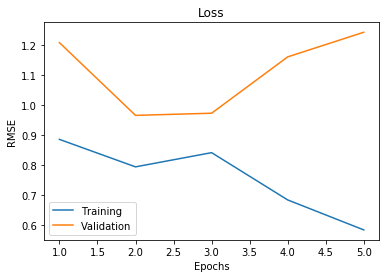


>> VALIDATION METRICS


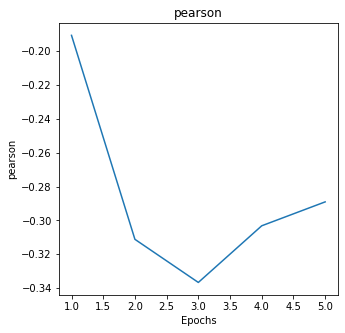

In [124]:
print('>> TRAINING / VALIDATION LOSS ')

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.title('Loss')
plt.show()

print('\n>> VALIDATION METRICS')
fig_size = 5
fig, axes = plt.subplots(1, len(metrics), figsize=(fig_size, fig_size * len(metrics)))
if not isinstance(axes, list):
    axes = [axes]

for ax, (name, metric_scores) in zip(axes, metrics.items()):
    ax.plot(np.arange(1, len(metric_scores) + 1, 1), metric_scores)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(name)
    ax.set_title(name)
fig.show()

### 4) BERT with Sentence Score

#### Pipeline

In [126]:
# Load tokenisers
print(f'Loading EN tokenizer...')
en_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
print('done!')
print()

print(f'Loading ZH tokenizer...')
zh_tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
print('done!')
print()


# Check tokenizers
sample_sent_id = 42
print('English')
print(train_en[sample_sent_id])
print(en_tokenizer.tokenize(train_en[sample_sent_id]))
print()

print('Chinese')
print(train_zh[sample_sent_id])
print(zh_tokenizer.tokenize(train_zh[sample_sent_id]))

Loading EN tokenizer...


100%|██████████| 213450/213450 [00:00<00:00, 325463.36B/s]


done!

Loading ZH tokenizer...


100%|██████████| 109540/109540 [00:00<00:00, 252663.64B/s]

done!

English
All 6 of the artillerymen recorded as wounded died).

['All', '6', 'of', 'the', 'artillery', '##men', 'recorded', 'as', 'wounded', 'died', ')', '.']

Chinese
据记录 ， 所有 6 名炮兵都受伤了) 。

['据', '记', '录', '，', '所', '有', '6', '名', '炮', '兵', '都', '受', '伤', '了', ')', '。']


In [0]:
train_en_inputs = sentence_groups_to_bert_tokens(en_tokenizer, train_en, max_length=128)
val_en_inputs = sentence_groups_to_bert_tokens(en_tokenizer, val_en, max_length=128)
test_en_inputs = sentence_groups_to_bert_tokens(en_tokenizer, test_en, max_length=128)

train_zh_inputs = sentence_groups_to_bert_tokens(zh_tokenizer, train_zh, max_length=128)
val_zh_inputs = sentence_groups_to_bert_tokens(zh_tokenizer, val_zh, max_length=128)
test_zh_inputs = sentence_groups_to_bert_tokens(zh_tokenizer, test_zh, max_length=128)

In [0]:
en_bert = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=1)

train_en_embs = get_bert_embeddings(en_bert, train_en_inputs)
val_en_embs = get_bert_embeddings(en_bert, val_en_inputs)
test_en_embs = get_bert_embeddings(en_bert, test_en_inputs)

100%|██████████| 404400730/404400730 [00:37<00:00, 10717101.36B/s]


In [0]:
zh_bert = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=1)

train_zh_embs = get_bert_embeddings(zh_bert, train_zh_inputs)
val_zh_embs = get_bert_embeddings(zh_bert, val_zh_inputs)
test_zh_embs = get_bert_embeddings(zh_bert, test_zh_inputs)

100%|██████████| 382072689/382072689 [00:36<00:00, 10346338.18B/s]


In [0]:
train_sent_scores = concat_zip(train_en_embs, train_zh_embs).numpy()
val_sent_scores = concat_zip(val_en_embs, val_zh_embs).numpy()
test_sent_scores = concat_zip(test_en_embs, test_zh_embs).numpy()

#### Model Architecture

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR

#### Model Selection

In [0]:
from sklearn.model_selection import cross_validate, KFold

def kfold_cross_validate_sklearn(model, train_inputs, train_scores, scoring,
                                 n_splits=10,
                                 random_state=0):
    if not isinstance(train_scores, np.ndarray):
        train_scores = np.array(train_scores)

    cv_split = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    result = cross_validate(model, train_inputs, train_scores,
                            cv=cv_split,
                            scoring=scoring)
    return result

In [0]:
from sklearn.metrics import mean_absolute_error

models_to_test = [('LinearRegression', LinearRegression()),
                  ('SVR(kernel=linear)', SVR(kernel='linear')),
                  ('SVR(kernel=rbf)', SVR(kernel='rbf')),
                  ('SVR(kernel=poly)', SVR(kernel='poly')),]

scoring = {'Pearson': pearson_sklearn,
           'MAE': make_scorer(mean_absolute_error)}

n_splits = 10
for name, model in models_to_test:
    print(name)
    print('=' * len(name))
    metrics = kfold_cross_validate_sklearn(model,
                                           train_sent_scores,
                                           train_scores,
                                           scoring,
                                           n_splits=n_splits)
    
    for name, scores in metrics.items():
        average = sum(scores) / n_splits
        print(f'  {name}\t: {average:.5f}')
    print()

LinearRegression
  fit_time	: 0.00092
  score_time	: 0.00046
  test_Pearson	: 0.00108
  test_MAE	: 0.73526

SVR(kernel=linear)
  fit_time	: 1.19880
  score_time	: 0.02080
  test_Pearson	: -0.00249
  test_MAE	: 0.69135

SVR(kernel=rbf)
  fit_time	: 1.90753
  score_time	: 0.07881
  test_Pearson	: 0.02229
  test_MAE	: 0.69134

SVR(kernel=poly)
  fit_time	: 2.51690
  score_time	: 0.02854
  test_Pearson	: 0.01833
  test_MAE	: 0.69112



#### Validation

In [125]:
# TODO: run on all 7000 

model = SVR(kernel='rbf')
model.fit(train_sent_scores, train_scores)

preds = model.predict(val_sent_scores)

NameError: ignored

### 5) BERT with Sentence-Pair Embeddings

#### Pipeline

In [47]:
# Load tokeniser
print(f'Loading tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=False)
print('done!')
print()

# Check tokeniser
sample_sent_id = 42

print('English')
print(train_en[sample_sent_id])
print(tokenizer.tokenize(train_en[sample_sent_id]))
print()

print('Chinese')
print(train_zh[sample_sent_id])
print(tokenizer.tokenize(train_zh[sample_sent_id]))

Loading tokenizer...


100%|██████████| 995526/995526 [00:01<00:00, 753518.56B/s]

done!

English
All 6 of the artillerymen recorded as wounded died).

['All', '6', 'of', 'the', 'artillery', '##men', 'recorded', 'as', 'wounded', 'died', ')', '.']

Chinese
据记录 ， 所有 6 名炮兵都受伤了) 。

['据', '记', '录', '，', '所', '有', '6', '名', '炮', '兵', '都', '受', '伤', '了', ')', '。']


In [0]:
train_inputs = sentence_groups_to_bert_tokens(tokenizer, train_en, train_zh, max_length=132)
val_inputs = sentence_groups_to_bert_tokens(tokenizer, val_en, val_zh, max_length=132)
test_inputs = sentence_groups_to_bert_tokens(tokenizer, test_en, test_zh, max_length=132)

In [49]:
# Load language model
bert = BertModel.from_pretrained('bert-base-multilingual-cased')
print(bert)

100%|██████████| 662804195/662804195 [01:05<00:00, 10104180.91B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Li

In [50]:
train_embeddings = get_bert_embeddings(bert, train_inputs)
train_embeddings_tensor = torch.cat(train_embeddings)

val_embeddings = get_bert_embeddings(bert, val_inputs)
val_embeddings_tensor = torch.cat(val_embeddings)

test_embeddings = get_bert_embeddings(bert, test_inputs)
test_embeddings_tensor = torch.cat(test_embeddings)

#### Model Architecture

In [0]:
class FFNNRegression(nn.Module):

    def __init__(self, *hidden_dims, input_dim=768, nonlin=F.relu):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.nonlin = nonlin

        prev_dim = input_dim
        for i, hidden_dim in enumerate(self.hidden_dims):
            setattr(self, f'hidden_{i}', nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim
        
        self.out = nn.Linear(prev_dim, 1)

    def forward(self, x):
        act = x
        for i, _ in enumerate(self.hidden_dims):
            layer = getattr(self, f'hidden_{i}')
            act = self.nonlin(layer(act))
        return self.out(act)

#### Model Selection

In [64]:
LR = 1e-2, 1e-3
NONLIN = F.relu, F.leaky_relu, torch.tanh, torch.sigmoid
LAYERS = [], (16,), (64,), (64, 16), (128, 64, 16),

non_loss_metrics = {'pearson': pearson}

for lr in LR:
    for nonlin in NONLIN:
        for arch in LAYERS:
            model = FFNNRegression(*arch, nonlin=nonlin)

            model_factory = torch_model_factory(model,
                                                opt=torch.optim.Adam,
                                                lr=lr,
                                                num_epochs=10,
                                                batch_size=7000,
                                                loss_fn=RMSELoss,
                                                detailed_log=False)
            
            print(train_embeddings_tensor.dtype)
            loss, metrics = torch_kfold_cross_validate(model_factory,
                                                       inputs=train_embeddings_tensor,
                                                      outputs=train_scores,
                                                        **non_loss_metrics)
            
            print(lr, nonlin.__name__, arch, loss, metrics)

torch.float32
>> Fold 1



>> Fold 2



0.01 relu [] tensor(0.9563) {'pearson': 0.13718296765162002}
torch.float32
>> Fold 1



>> Fold 2



0.01 relu (16,) tensor(0.9374) {'pearson': 0.015208496953507677}
torch.float32
>> Fold 1



>> Fold 2



0.01 relu (64,) tensor(0.9526) {'pearson': 0.022318740270352085}
torch.float32
>> Fold 1



>> Fold 2



0.01 relu (64, 16) tensor(0.9270) {'pearson': 0.042716069502253456}
torch.float32
>> Fold 1



>> Fold 2



0.01 relu (128, 64, 16) tensor(0.9286) {'pearson': 0.002200923550609366}
torch.float32
>> Fold 1



>> Fold 2



0.01 leaky_relu [] tensor(0.9627) {'pearson': 0.07827093407779975}
torch.float32
>> Fold 1



>> Fold 2



0.01 leaky_relu (16,) tensor(0.9341) {'pearson': 0.012622822248298284}
torch.float32
>> Fold 1



>> Fold 2



0.01 leaky_relu (64,) tensor(0.9555) {'pearson': 0.02271833840473102}
torch.float32
>> Fold 1



>> Fold 2



0.01 leaky_relu (64, 16) tensor(0.9317) {'pearson': 0.04239769051706194}
torch.float32
>> Fold 1



>> Fold 2



0.01 leaky_relu (128, 64, 16) tensor(0.9292) {'pearson': 0.016503815553058104}
torch.float32
>> Fold 1



>> Fold 2



0.01 tanh [] tensor(0.9627) {'pearson': 0.07827093407779975}
torch.float32
>> Fold 1



>> Fold 2



0.01 tanh (16,) tensor(0.9333) {'pearson': 0.037808424085138015}
torch.float32
>> Fold 1



>> Fold 2



0.01 tanh (64,) tensor(0.9517) {'pearson': 0.050019511947036674}
torch.float32
>> Fold 1



>> Fold 2



0.01 tanh (64, 16) tensor(0.9321) {'pearson': -0.050072029894370304}
torch.float32
>> Fold 1



>> Fold 2



0.01 tanh (128, 64, 16) tensor(0.9288) {'pearson': 0.0108199382577389}
torch.float32
>> Fold 1



>> Fold 2



0.01 sigmoid [] tensor(0.9627) {'pearson': 0.07827093407779975}
torch.float32
>> Fold 1



>> Fold 2



0.01 sigmoid (16,) tensor(0.9418) {'pearson': 0.08461665973185904}
torch.float32
>> Fold 1



>> Fold 2



0.01 sigmoid (64,) tensor(0.9595) {'pearson': 0.048094010029652405}
torch.float32
>> Fold 1



>> Fold 2



0.01 sigmoid (64, 16) tensor(0.9285) {'pearson': 0.05770119558633443}
torch.float32
>> Fold 1



>> Fold 2



0.01 sigmoid (128, 64, 16) tensor(0.9293) {'pearson': 0.030200482388114118}
torch.float32
>> Fold 1



>> Fold 2



0.001 relu [] tensor(0.9261) {'pearson': 0.08904997276402499}
torch.float32
>> Fold 1



>> Fold 2



0.001 relu (16,) tensor(0.9211) {'pearson': 0.14136271379074425}
torch.float32
>> Fold 1



>> Fold 2



0.001 relu (64,) tensor(0.9238) {'pearson': 0.11787632796145106}
torch.float32
>> Fold 1



>> Fold 2



0.001 relu (64, 16) tensor(0.9216) {'pearson': 0.156875530560159}
torch.float32
>> Fold 1



>> Fold 2


KeyboardInterrupt: ignored

#### Validation

In [0]:
# TODO